In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [10]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior, lr=0.1):
        super().__init__()
        
        self.prior_all = prior(torch.zeros(2), torch.eye(2))
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
        # nn.Parameters has to be used to prevent memory leaks.
        with torch.no_grad():
            self.lr = lr
            self.mu0 = nn.Parameter(torch.zeros(2), requires_grad=False) 
            self.mu1 = nn.Parameter(torch.zeros(2), requires_grad=False)
            self.s0 = nn.Parameter(torch.eye(2), requires_grad=False)
            self.s1 = nn.Parameter(torch.eye(2), requires_grad=False)      
        
    def f(self, x):
        log_det_J = x.new_zeros(x.shape[0])
        for translate, scale, mask in zip(self.t, self.s, self.mask):
            x1 = y1 = x * mask
            x2 = x * (1 - mask)
            s = scale(x1) * (1 - mask)
            t = translate(x1) * (1 - mask)
            y2 = x2 * torch.exp(s) + t
            x = y1 + y2
            log_det_J += s.sum(dim=1)
        y = x
        return y, log_det_J

    def g(self, y):
        for translate, scale, mask in zip(reversed(self.t), reversed(self.s), reversed(self.mask)):
            y1 = x1 = y * mask
            y2 = y * (1 - mask)
            s = scale(y1) * (1 - mask)
            t = translate(y1) * (1 - mask)
            x2 = (y2 - t) * torch.exp(-s)
            y = x1 + x2
        x = y
        return x
    
    def log_prob(self, x):
        y, logp = self.f(x)
        return self.prior_all.log_prob(y) + logp, y
    
    def train_latent_space(self, z, label):
        with torch.no_grad():
            label = label.bool()
            m0 = torch.mean(z[label], 0)
            m1 = torch.mean(z[~label], 0)
            self.mu0.copy_((1 - self.lr) * self.mu0 + self.lr * m0)
            self.mu1.copy_((1 - self.lr) * self.mu1 + self.lr * m1)
            z0 = z[label] - m0
            z1 = z[~label] - m1
            self.s0.copy_((1 - self.lr) * self.s0 + self.lr * (z0.T @ z0 / (z0.shape[0] - 1)))
            self.s1.copy_((1 - self.lr) * self.s1 + self.lr * (z1.T @ z1 / (z1.shape[0] - 1)))
        
    def sample(self, batchSize):
        y0 = self.prior(self.mu0, self.s0).sample((batchSize, 1))
        x0 = self.g(y0)
        y1 = self.prior(self.mu1, self.s1).sample((batchSize, 1))
        x1 = self.g(y1)
        return x0, x1, y0, y1

In [11]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Sigmoid())
"""
nets (net scale)
nets nodes: 2 input nodes, 64 hidden nodes, 64 hidden nodes, 2 output nodes
activations are Relu and last Tanh.
"""
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
"""
nett (net translation)
nett nodes: 2 input nodes, 64 hidden nodes, 64 hidden nodes, 2 output nodes
activations are Relu and no end activation. 
"""
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) #6 coupling layers alternating
prior = distributions.MultivariateNormal #2D gaussian no correlation
flow = RealNVP(nets, nett, masks, prior)

In [12]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(10001):    
    noisy_moons, label = datasets.make_moons(n_samples=64, noise=.05)
    label = torch.from_numpy(label)
    x = torch.from_numpy(noisy_moons.astype(np.float32))
    loss, z = flow.log_prob(x)
    loss = -loss.mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    flow.train_latent_space(z, label)
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 13.360
iter 500: loss = 0.966
iter 1000: loss = 0.634
iter 1500: loss = 0.595
iter 2000: loss = 0.627
iter 2500: loss = 0.732
iter 3000: loss = 0.505
iter 3500: loss = 0.502
iter 4000: loss = 0.610
iter 4500: loss = 0.582
iter 5000: loss = 0.501
iter 5500: loss = 0.500
iter 6000: loss = 0.539
iter 6500: loss = 0.407
iter 7000: loss = 0.314
iter 7500: loss = 0.546
iter 8000: loss = 0.483
iter 8500: loss = 0.351
iter 9000: loss = 0.567
iter 9500: loss = 0.612
iter 10000: loss = 0.383


Text(0.5, 1.0, '$X = g(z)$')

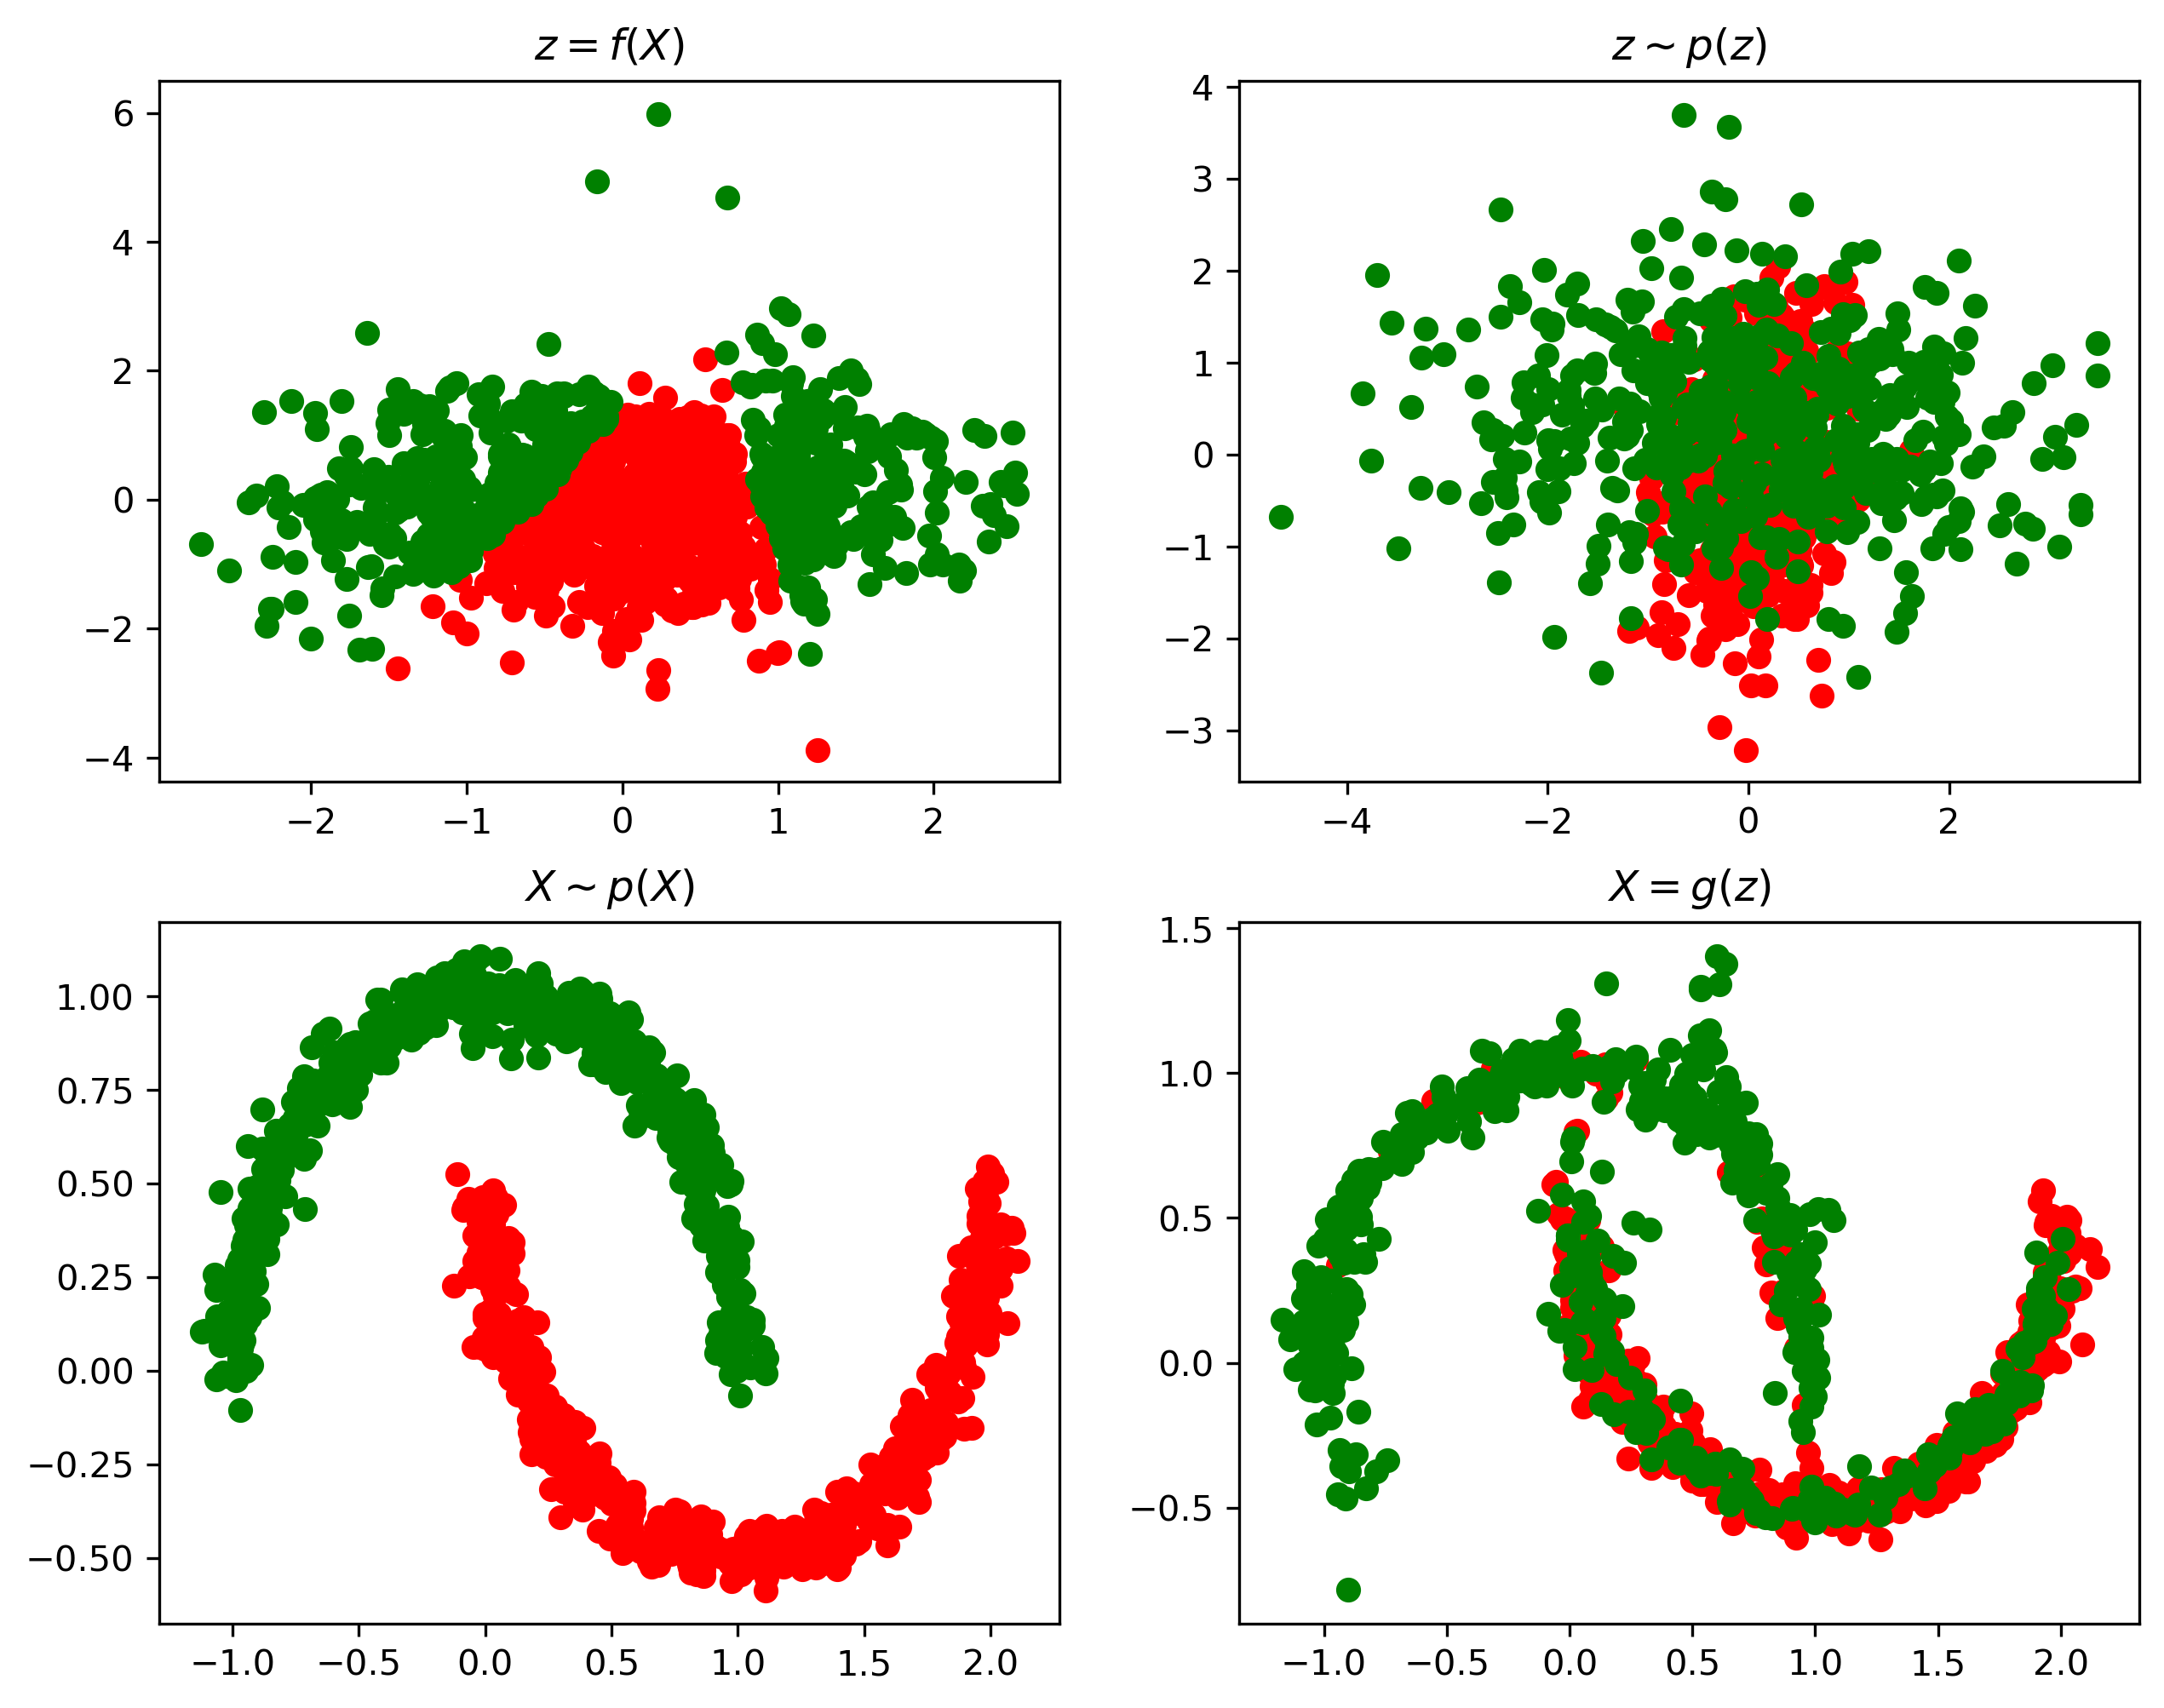

In [14]:
noisy_moons, label = datasets.make_moons(n_samples=1000, noise=.05)
u = torch.zeros((1000,2))
l = torch.from_numpy(label)
u[:,0] = l
u[:,1] = 1-l
label = label.astype(bool)

z = flow.f(torch.from_numpy(noisy_moons.astype(np.float32)))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[label, 0], z[label, 1], c='r')
plt.scatter(z[~label, 0], z[~label, 1], c='g')
plt.title(r'$z = f(X)$')

# z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
# plt.subplot(222)
# plt.scatter(z[:, 0], z[:, 1])
# plt.title(r'$z \sim p(z)$')

plt.subplot(222)
x0, x1, y0, y1 = flow.sample(500)
x0 = x0.detach().numpy()
x1 = x1.detach().numpy()
y0 = y0.detach().numpy()
y1 = y1.detach().numpy()
plt.scatter(y0[:, 0, 0], y0[:, 0, 1], c='r')
plt.scatter(y1[:, 0, 0], y1[:, 0, 1], c='g')
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x, y = datasets.make_moons(n_samples=1000, noise=.05)
x = x.astype(np.float32)
y = y.astype(bool)
plt.scatter(x[y, 0], x[y, 1], c='r')
plt.scatter(x[~y, 0], x[~y, 1], c='g')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
plt.scatter(x0[:, 0, 0], x0[:, 0, 1], c='r')
plt.scatter(x1[:, 0, 0], x1[:, 0, 1], c='g')
plt.title(r'$X = g(z)$')

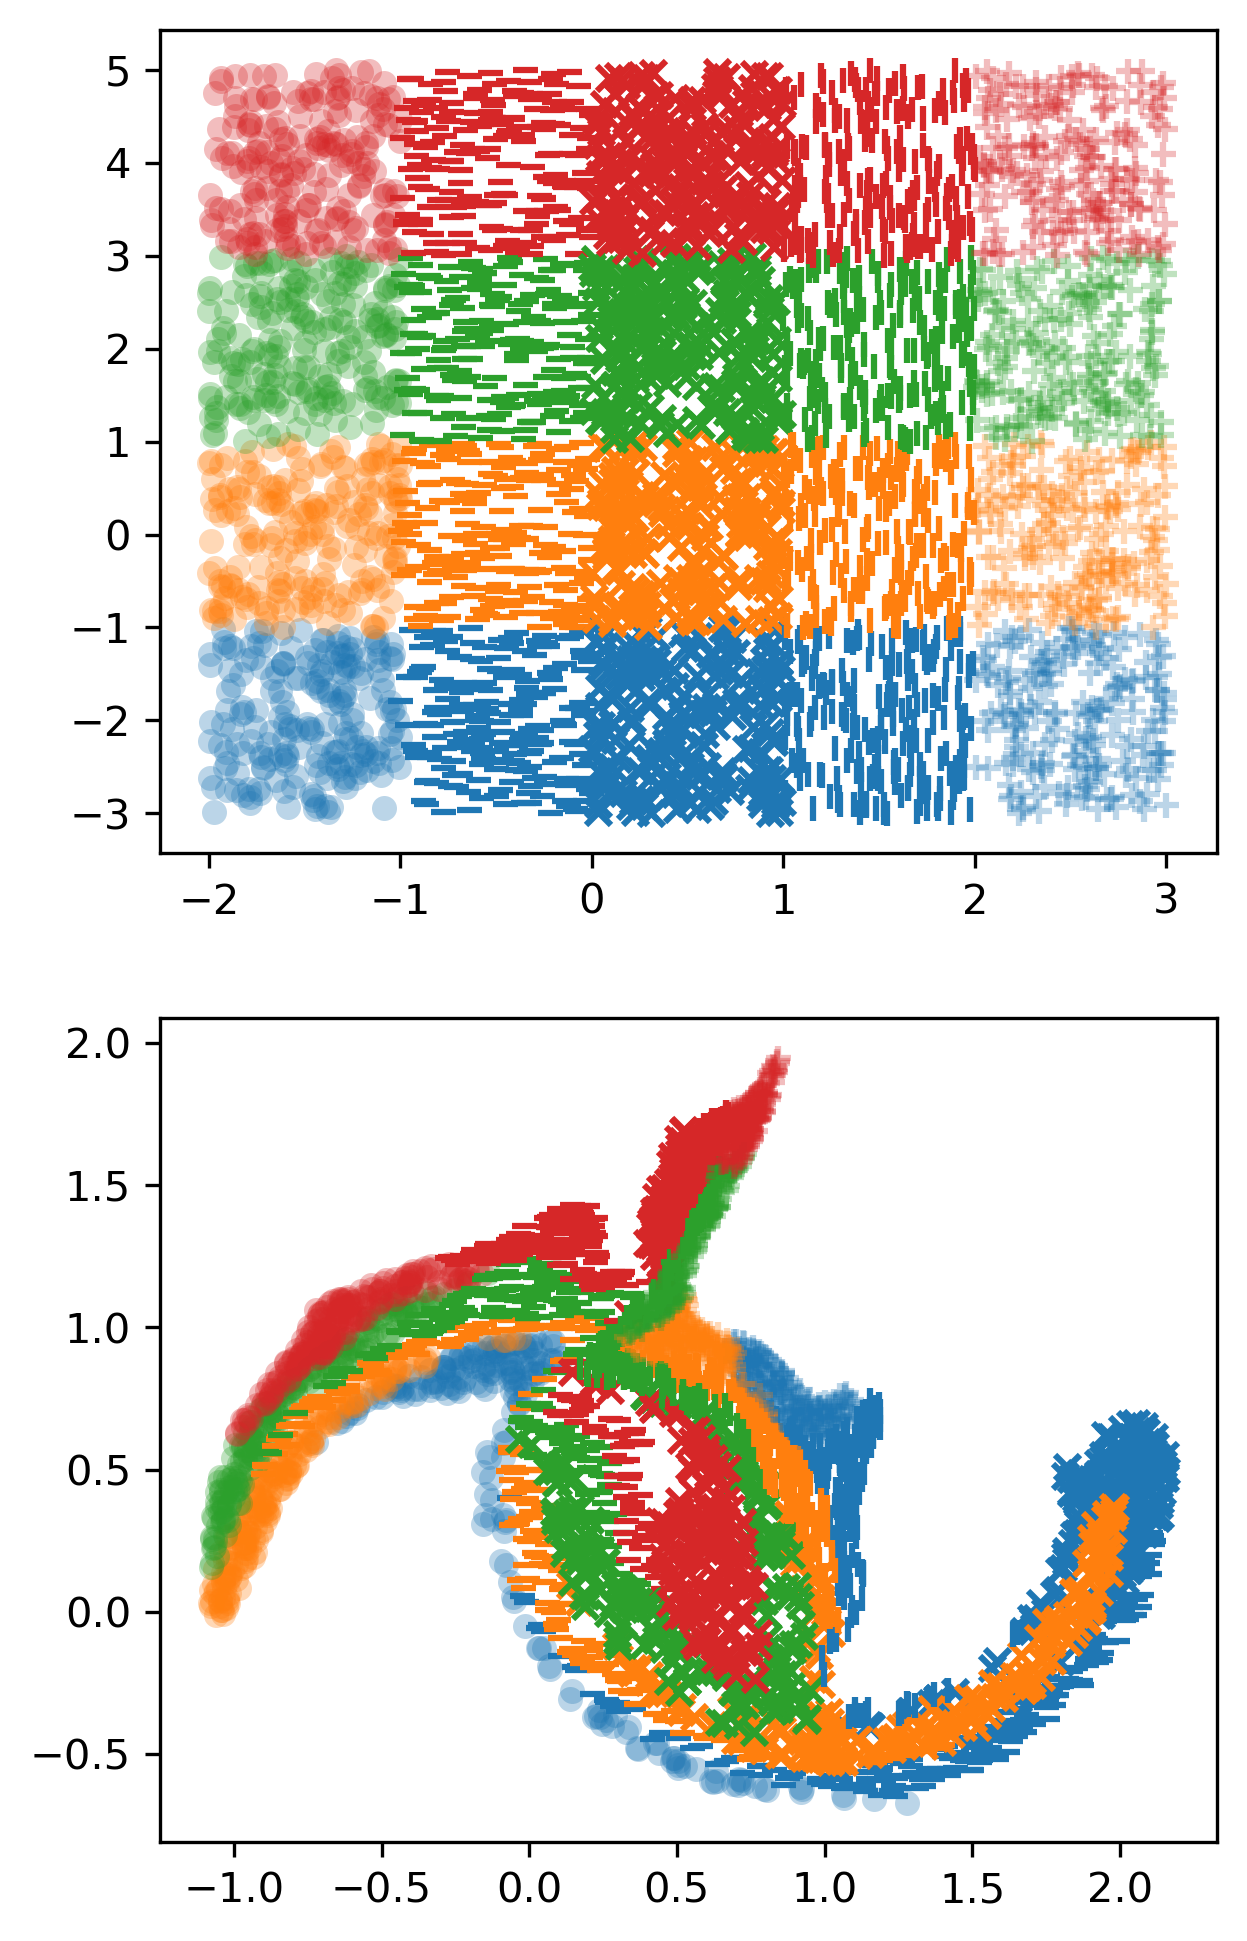

In [15]:
n = 200
xstep = 1
ystep = 2
cycle = 4
markers = ['o', '_', 'x', '|', '+', '*']
alphas = [0.3, 1, 1, 1, 0.3, 0.5, 0.5, 1] 
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
block = []
for i in range(-2, 3, xstep):
    for j in range(-3, 5, ystep):
        block.append((torch.FloatTensor(n).uniform_(i, i+xstep),
                      torch.FloatTensor(n).uniform_(j, j+ystep))) 


plt.subplot(221)
i = 0
for x, y in block:
    plt.scatter(x, y, linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
    i += 1
    
plt.subplot(223)
i = 0
for x, y in block:
    z = flow.g(torch.stack((x, y)).T).detach().numpy()
    plt.scatter(z[:,0], z[:,1], linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
    i += 1
    